# musiGAN

**Description:** 1-Track MuseGAN architecture build on MiniGAN.\
**Purpose:** implement a composing GAN.\
**Results:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

## Model

### Support classes

In [2]:
# code from https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html#:~:text=A%20straight%2Dthrough%20estimator%20is,function%20was%20an%20identity%20function.

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return torch.nn.functional.hardtanh(grad_output)

class StraightThroughEstimator(torch.nn.Module):
    def __init__(self):
        super(StraightThroughEstimator, self).__init__()

    def forward(self, x):
        x = STEFunction.apply(x)
        return x

### musiGAN

#### Generator

In [5]:
class GeneratorBlock(torch.nn.Module):
    """ 2d transconv layer, batch normalization & ReLU """

    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()

        self.gen_block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_dim, out_dim, kernel, stride),
            torch.nn.BatchNorm2d(out_dim),
            torch.nn.ReLU()
            )

    def forward(self, x):
        return self.gen_block(x)

In [33]:
class Generator (torch.nn.Module) :
    """
    1-track museGAN generator, consisting of two sub-networks (so-called 
    temporal and bar generator)

    input : seed vector, a normally distributed random vector, 
            length: (B + 1) * 64 = 5 * 64 here
    output: pianaroll, binary tensor, shape: (B x T x P) = (4 x 96 x 84) here
    """

    def __init__ (self, log = False, **kwargs) : 
        super().__init__(**kwargs)
        
        self.temporal_generator = torch.nn.Sequential(
            
            # heuristically added linear layer
            torch.nn.Linear(1, 31),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),

            # transconv layer 1
            torch.nn.ConvTranspose1d(64, 1024, 2, 2),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),

            # transconv layer 2
            torch.nn.ConvTranspose1d(1024, 1, 3, 1),
            torch.nn.BatchNorm1d(1),
            torch.nn.ReLU()
        )

        self.bar_generator = torch.nn.Sequential(
            
            # transconv layers
            GeneratorBlock( 128, 1024, (2, 1), (2, 1)),
            GeneratorBlock(1024,  256, (2, 1), (2, 1)),
            # GeneratorBlock( 512,  256, (2, 1), (2, 1)), heuristically omit
            GeneratorBlock( 256,  256, (2, 1), (2, 1)),
            GeneratorBlock( 256,  128, (3, 1), (3, 1)),
            GeneratorBlock( 128,   64, (1, 7), (1, 7)),

            # last layer with tanh & binarization activation fct.s
            torch.nn.ConvTranspose2d(64, 1, (1, 12), (1, 12)),
            torch.nn.BatchNorm2d(1),
            torch.nn.Tanh(),
            StraightThroughEstimator() # binarization
        )

        if log :
            print(f"Generator: parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


    def forward (self, seed) :
        seeds = torch.chunk(seed, chunks = 5, dim = 1)
        
        # create time-independent first half of seed for bar generator
        bar_seed_1 = seeds[0]
        bar_seed_1 = bar_seed_1.view((-1, 64, 1, 1)) # reshape for transconv layers

        # generate pianorolls bar by bar
        generated_bars = []
        for temporal_seed in seeds[1:]:
            
            ## generate time-dependent second half of seed for bar generator
            
            temporal_seed = temporal_seed.view(-1, 64, 1) # reshape for transconv layers
            # print(f"temporal seed: {temporal_seed.size()}")
            bar_seed_2 = self.temporal_generator(temporal_seed) # (batch size x 1 x 64)
            # print(f"bar seed 2: {bar_seed_2.size()}")

            ## reshape & concatenate both halfs of seed for bar generator 
            
            bar_seed_2 = bar_seed_2.view(-1, 64, 1, 1)
            bar_seed = torch.cat((bar_seed_1, bar_seed_2), dim = 1) # (batch size x 128 x 1 x 1)
            # print(f"bar seed: {bar_seed.size()}")

            ## generate one bar 
            
            generated_bar = self.bar_generator(bar_seed) # (batch size x 1 x 24 x 84)
            # print(f"bar seed: {generated_bar.size()}")
            generated_bars.append(generated_bar) 

        pianoroll = torch.cat(generated_bars, dim = 1) # (batch size x 4 x 24 x 84) 
        # print(f"output: {pianoroll.size()}")

        return pianoroll

#### Discriminator

In [7]:
class DiscriminatorBlock(torch.nn.Module):
    """3d conv layer & Leaky ReLU"""

    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.dis_block = torch.nn.Sequential(
            torch.nn.Conv3d(in_dim, out_dim, kernel, stride),
            torch.nn.LeakyReLU(negative_slope = 0.2) # MuseGAN Hyperparameter
            )

    def forward(self, x):
        return self.dis_block(x)

In [72]:
class Discriminator (torch.nn.Module) :
    """
    1-Track museGAN discriminator
    
    input : (B x T x P) binary pianoroll
    output: single number, prob. that the input pianoroll is a 
            real and not generated
    """


    def __init__ (self, log = False, **kwargs) :
        super().__init__(**kwargs)

        # conv layers
        self.discriminator_conv = torch.nn.Sequential(
            DiscriminatorBlock(  1, 128, (2, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (3, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (1, 1, 12), (1, 1, 12)), 
            DiscriminatorBlock(128, 128, (1, 1,  7), (1, 1,  7)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            # DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)), heuristically omit
            DiscriminatorBlock(128, 256, (1, 4,  1), (1, 2,  1)),
            DiscriminatorBlock(256, 512, (1, 3,  1), (1, 2,  1)))
        
        # fully-connected layers
        self.discriminator_fc = torch.nn.Sequential(
            torch.nn.Linear(512 * 2, 1024),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(1024, 1))
        
        if log :
            print(f"Discriminator parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward (self, pianoroll):
        pianoroll = pianoroll.view(-1, 1, 4, 24, 84) # reshape for transconvs
        conv_output = self.discriminator_conv(pianoroll)
        # print(conv_output.size())
        fc_input = conv_output.view(-1, 2*512)
        judgement = self.discriminator_fc(fc_input).flatten().float()
        return judgement

#### Architecture Tests

Generator: parameters: 1216516



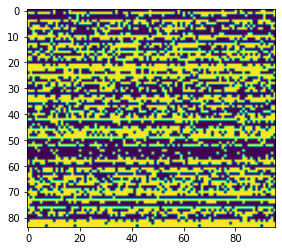

In [42]:
# test generator

gen = Generator(log=True)
gen_out = gen.forward(torch.rand(10, 5*64))
pr = gen_out.cpu().detach().numpy()
pr = pr.reshape((10, 4 * 24, 84))

plt.imshow(pr[0].T)

In [43]:
# test discriminator

dis = Discriminator(log=True)

dis_out = dis.forward(gen_out)
judge = torch.sigmoid(dis_out).cpu().detach().numpy().flatten()

print(f"Prob. that image is real: {judge[0]*100:.0f}%")

Discriminator parameters: 1969793

torch.Size([10, 512, 1, 2, 1])
Prob. that image is real: 49%


## Training classes

In [ ]:
def quick_test(GEN, DIS, data): 
    
    # Test on generated data
    
    ## Generator
    test_seeds = torch.normal(0, 1, (5, seed_length))
    examples = GEN.forward(test_seeds)
    gen_img = examples[0].reshape(number_pitches, number_blips)
    gen_img = gen_img.detach().numpy()

    ## Discriminator
    gen_judgements = DIS.forward(examples)
    gen_judgement = torch.sigmoid(gen_judgements[0][0]).detach().numpy()

    # Results
    plt.title("Generator output x")
    plt.imshow(gen_img);
    print(f"Discriminator p(x_gen = real): {gen_judgement*100:.0f}%")

    # Test on real data
    real_judgement = torch.sigmoid(DIS.forward(data))[0][0].detach().numpy()
    print(f"Discriminator p(x_real = real) = {real_judgement*100:.0f}%")

In [ ]:
def generator_goodness(generated_batch, real_batch):
    """ compare two batches of data by calculating the absolute mean difference"""
    
    # averaged over batches 
    generated_mean = torch.mean(generated_batch)
    real_mean = torch.mean(real_batch)

    # take differnece & absolut value, average over features lastly
    goodness_criteria = torch.mean(torch.abs(real_mean - generated_mean))

    return(goodness_criteria.detach().numpy())

### Training Class

In [77]:
class Training :
    def __init__ (self, real_pianorolls, batch_size) :
        self.device = 'cuda'  if torch.cuda.is_available() else  'cpu'

        # Storing external parameters
        self.batch_size  = batch_size
        self.seed_length = 64 * 5
        
        # Preparing training data
        self.training_set = real_pianorolls
        self.data_loader  = torch.utils.data.DataLoader(self.training_set,
                                batch_size = self.batch_size, 
                                drop_last = True,
                                shuffle = True)

        # Initializing GAN
        self.gen = Generator().to(self.device)
        self.dis = Discriminator().to(self.device)
        self.optimizer_gen = torch.optim.Adam(self.gen.parameters(), 
                                              lr = 0.001,
                                              betas = (0.5, 0.9)) 
            # ADAM parameters from GAN tutorial
        self.optimizer_dis = torch.optim.Adam(self.dis.parameters(), 
                                              lr = 0.001,
                                              betas = (0.5, 0.9))



    def train (self, epochs, k = 1, loss_func = "WGAN") :
        # Training parameters
        self.k = k
        self.loss_function = loss_func

        assert  type(epochs) == int
        assert  epochs >= 1
        assert  type(k) == int
        assert  k >= 1
        assert  self.loss_function in ["GAN", "WGAN"]
        
        # Logging
        self.losses       = np.zeros((5, epochs))
        self.probs        = np.zeros((2, epochs))
        self.gen_goodness = np.zeros(epochs)
        

        # Main training loop
        for epoch in range(epochs) :
            loss         = []
            probs        = []
            gen_goodness = []

            for train_batch in self.data_loader :
                batch_losses, batch_probs, batch_gen_goodness = \
                    self.training_step(train_batch[0].to(self.device))
                loss.append(batch_losses)
                probs.append(batch_probs)
                gen_goodness.append(batch_gen_goodness)
                print("#", end = "")
            
            # Loging
            self.losses[:, epoch]    = np.array(loss).mean(axis=0)
            self.probs[:, epoch]     = np.array(probs).mean(axis=0)
            self.gen_goodness[epoch] = np.array(gen_goodness).mean(axis=0)

            print(" epoch", epoch, "complete.")

        # Returning trained GAN
        return self.gen, self.dis

  

    def training_step (self, batch_real) :
        dis_losses = torch.zeros(size = (self.k,)).to(self.device)  # logging
        for i in range(self.k):
            # Forward propagation
            seed_vector = torch.normal(0, 1, size = 
                                       (self.batch_size, self.seed_length)) \
                          .to(self.device)
            batch_gen = self.gen.forward(seed_vector)
            
            judgement_real = self.dis.forward(batch_real)
            judgement_gen  = self.dis.forward(batch_gen)
            print(judgement_gen)

            # Calculating the Discriminator loss function
            if self.loss_function == "GAN" :
                prob_real = torch.sigmoid(judgement_real)
                prob_gen  = torch.sigmoid(judgement_gen)
                loss_term_real = - torch.mean(torch.log(prob_real))
                loss_term_gen  = torch.mean(torch.log(1 - prob_gen))
                reg_term       = torch.tensor(0.)
            elif self.loss_function == "WGAN" :
                loss_term_real = - torch.mean(judgement_real)
                loss_term_gen  = torch.mean(judgement_gen)
                var_g    = torch.var(judgement_gen)
                var_r    = torch.var(judgement_real)
                reg_term = torch.where(var_g > 1, (var_g - 1)**2, 0) \
                           + torch.where(var_r > 1, (var_r - 1)**2, 0)
            else :
                print(f"Warning: '{self.loss_function}' loss function isn't\
                        an option!")

            loss_dis = loss_term_real + loss_term_gen + reg_term
            
            # Discriminator update
            self.optimizer_dis.zero_grad()
            loss_dis.backward(retain_graph = True)
            self.optimizer_dis.step()
            
            dis_losses[i] = loss_dis   # logging

        loss_dis = torch.mean(dis_losses)  # logging


        # Calculating the Generator loss function
        judgement_new = self.dis.forward(batch_gen)
        
        if self.loss_function == "GAN" :
            prob_new = torch.sigmoid(judgement_new)
            loss_gen = -torch.mean(torch.log(prob_new)) 
        elif self.loss_function == "WGAN" :
            loss_gen = -torch.mean(judgement_new)
        
        # Generator update
        self.optimizer_gen.zero_grad()
        loss_gen.backward()
        self.optimizer_gen.step()

        # Output Losses
        losses_out = [loss_dis.detach().numpy(), 
                      loss_term_real.detach().numpy(), 
                      loss_term_gen.detach().numpy(), 
                      reg_term.detach().numpy(), 
                      loss_gen.detach().numpy()]

        # Output averaged judgement probabilities 
        D_real = torch.mean(torch.sigmoid(judgement_real))
        D_gen  = torch.mean(torch.sigmoid(judgement_gen))
        probs_out = [D_real.detach().numpy(), D_gen.detach().numpy()]

        # Output generator goodness (already averaged over batch)
        gen_goodness = generator_goodness(batch_gen, batch_real)

        # Quick Test for debugging 
        # quick_test(self.gen, self.dis) 

        return losses_out, probs_out, gen_goodness



    def save (self, name) :
        file_name = training_filepath + name + ".obj"
        file      = open(file_name, "wb")
        pickle.dump(self, file)
        print(f"Saved training under '{file_name}'")


    def load (name) :
        file_name = training_filepath + name + ".obj"
        file      = open(file_name, "rb")
        return pickle.load(file)

## Training the model

In [73]:
# load data

file_directory = "../data_preparation/prepared_data/lpd5_full_4bars"
loaded_data = np.load(file_directory + "/prepared_arrays.npz")
loaded_data_array, _ = loaded_data["data"], loaded_data["labels"]

# convert to pytorch tensor
data_tensor = torch.as_tensor(loaded_data_array, dtype=torch.float32) 

# reshape for model input 
n_instances, n_timesteps, n_pitches = data_tensor.size() # (shape: n_instances x n_timesteps x n_pitches)
data_tensor = data_tensor.view(n_instances, 4, int(n_timesteps / 4), n_pitches) 
data_tensor = data_tensor.view(n_instances, 1, 4, int(n_timesteps / 4), n_pitches) 

# create pytorch dataset & dataloader
lpd5_dataset = torch.utils.data.TensorDataset(data_tensor)

In [78]:
GANTrainer  = Training(lpd5_dataset, batch_size = 20)
trained_GAN = GANTrainer.train(epochs = 1, k = 5, loss_func="WGAN")

tensor([-0.0209, -0.0213, -0.0212, -0.0208, -0.0211, -0.0211, -0.0208, -0.0213,
        -0.0212, -0.0210, -0.0210, -0.0211, -0.0210, -0.0211, -0.0211, -0.0209,
        -0.0211, -0.0209, -0.0209, -0.0213], grad_fn=<ReshapeAliasBackward0>)


RuntimeError: expected scalar type float but found long long

In [ ]:
# storage
training_filepath = "../execution/trained_models/"

GANTrainer.save("MusiGAN - Test")

## Junk & quick tests